In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms as T
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import OneCycleLR
DATA_ROOT = pathlib.Path("/kaggle/input/eurosat-dataset/EuroSAT/")

train_df = pd.read_csv(DATA_ROOT / "train.csv", index_col=0).reset_index(drop=True)
valid_df = pd.read_csv(DATA_ROOT / "validation.csv", index_col=0).reset_index(drop=True)
test_df = pd.read_csv(DATA_ROOT / "test.csv", index_col=0).reset_index(drop=True)
train_df.head()

,Filename,Label,ClassName
0,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,Industrial/Industrial_453.jpg,4,Industrial
4,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
import pandas as pd
import pathlib
DATA_ROOT = pathlib.Path("/kaggle/input/eurosat-dataset/EuroSAT/")


class EuroSATDataset(Dataset):
    def __init__(self, annotation_df, train=False):
        self.df = annotation_df
        self.train = train

        if train:
            self.transform = T.Compose([
                T.ConvertImageDtype(torch.float32),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomRotation(20),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = T.Compose([
                T.ConvertImageDtype(torch.float32),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img_path = (DATA_ROOT / sample["Filename"]).as_posix()
        img = read_image(img_path)
        img = self.transform(img)
        label = torch.tensor(sample["Label"])
        return img, label

In [4]:
import multiprocessing

import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import torch.optim

class EuroSATLightningDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, num_workers=3):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_data = EuroSATDataset(train_df, train=True)
        self.valid_data = EuroSATDataset(valid_df, train=False)
        self.test_data  = EuroSATDataset(test_df, train=False)

    def _loader(self, dataset, shuffle=False):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=shuffle,
        )

    def train_dataloader(self):
        return self._loader(self.train_data, shuffle=True)

    def val_dataloader(self):
        return self._loader(self.valid_data)

    def test_dataloader(self):
        return self._loader(self.test_data)

    def predict_dataloader(self):
        return self._dataloader(self.test_data)


class EuroSATLightningModule(pl.LightningModule):
    def __init__(self, num_classes=10, lr=3e-4):
        super().__init__()
        self.lr = lr

        # ----------------------------------------------------
        # 1) Pretrained ResNet50 로드
        # ----------------------------------------------------
        local_weight_path = "/kaggle/input/resnet50/resnet50-11ad3fa6.pth"
        # self.model = models.resnet50(weights="IMAGENET1K_V2")
        self.model = torchvision.models.resnet50(weights=None)
        state = torch.load(local_weight_path, map_location="cpu")
        self.model.load_state_dict(state)
        
        # ----------------------------------------------------
        # 2) 마지막 FC 바꾸기
        # ----------------------------------------------------
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)      # raw logits (log_softmax 제거)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=10)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)

        steps_per_epoch = len(train_df) // 64

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.lr,
            epochs=15,
            steps_per_epoch=steps_per_epoch,
        )

        return {"optimizer": optimizer, 
                "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

In [5]:
# from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning.loggers import CSVLogger

# datamodule = EuroSATLightningDataModule(batch_size=128)
# model = EuroSATLightningModule(
#     datamodule.num_classes, 
#     datamodule.num_samples, 
#     datamodule.batch_size, 
#     lr=3e-5,
# )

# trainer = pl.Trainer(
#     max_epochs=50,
#     logger=CSVLogger(save_dir="logs/"),
#     callbacks=[
#         EarlyStopping(monitor="val_loss", patience=5, mode="min")
#     ],
#     log_every_n_steps=10,
#     accelerator="gpu",     # GPU
#     devices=1,             # 1 GPU
#     precision="16-mixed",  # GPU mixed precision
# )

# trainer.fit(model, datamodule)
# trainer.test(model, datamodule)
import time
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
from pytorch_lightning.callbacks import Timer

# -----------------------------
# 1) 전체 셀 실행 시간 측정 시작
# -----------------------------
start_time = time.time()

# -----------------------------
# 2) DataModule & Model
# -----------------------------
datamodule = EuroSATLightningDataModule(batch_size=64)
model = EuroSATLightningModule(num_classes=10, lr=3e-4)

# -----------------------------
# 3) Progress bar & Timer 설정
# -----------------------------
timer = Timer(
    interval="epoch",    # epoch마다 시간 기록
    verbose=True         # 콘솔에 출력
)

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu",
    devices=1,
    precision="32",
    logger=CSVLogger("logs/"),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        RichProgressBar(),
        timer,    # epoch 시간 측정 추가
    ],
)

# -----------------------------
# 4) Training
# -----------------------------
print("\n🚀 Training started...\n")
trainer.fit(model, datamodule)

# -----------------------------
# 5) Testing
# -----------------------------
trainer.test(model, datamodule)

# -----------------------------
# 6) 전체 셀 실행 시간 출력
# -----------------------------
end_time = time.time()
print("\n⏱️ 전체 셀 실행 시간:")
print(f"{(end_time - start_time) / 60:.2f} 분")

# -----------------------------
# 7) epoch 별 시간 출력
# -----------------------------
print("\n⏱️ Epoch-wise timings:")
print(timer.time_elapsed())


🚀 Training started...



┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ ResNet │ 23.5 M │
└───┴───────┴────────┴────────┘

Trainable params: 23.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9755555391311646     │
│         test_loss         │    0.07945060729980469    │
└───────────────────────────┴───────────────────────────┘


⏱️ 전체 셀 실행 시간:
3.83 분

⏱️ Epoch-wise timings:
216.906083528


,test_acc,test_loss,train_loss,val_acc,val_loss
epoch,,,,,
0,NaN,NaN,2.209426,NaN,NaN
0,NaN,NaN,2.154744,NaN,NaN
0,NaN,NaN,1.863456,NaN,NaN
0,NaN,NaN,1.427641,NaN,NaN
0,NaN,NaN,0.779983,NaN,NaN


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


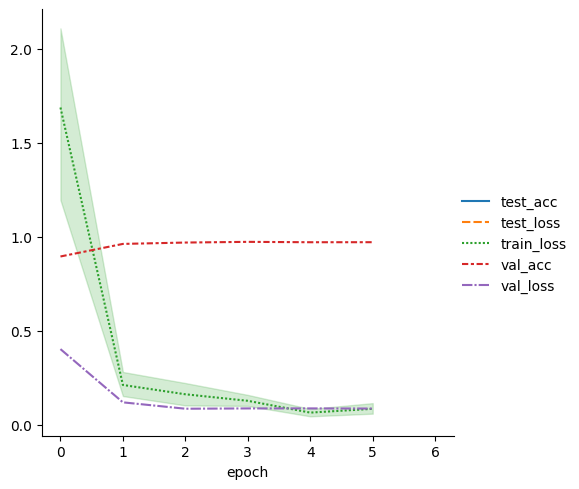

In [6]:
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [8]:
torch.save(model.state_dict(), "resnet50_eurosat_best.pth")
print("모델 저장 완료!")

모델 저장 완료!
